# KPI Data Analysis for Work Utilization

This notebook connects to SQL Server, retrieves KPI data for different punch codes, and visualizes the trends over time.


In [1]:
pip install sqlalchemy

  Using cached sqlalchemy-2.0.40-cp313-cp313-win_amd64.whl.metadata (9.9 kB)
Using cached sqlalchemy-2.0.40-cp313-cp313-win_amd64.whl (2.1 MB)

   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   ---------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sqlalchemy import create_engine
import urllib.parse
import warnings

In [50]:
# Set plot styling
plt.style.use('ggplot')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')

# Configure plot size and resolution
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [51]:
### SQL Server Connection

# SQL Server connection parameters - replace with your own values
server = 'fsdhastp01'
database = 'ABC'
# use Windows Authentication
username = 'YOUR_USERNAME'  
password = 'YOUR_PASSWORD' 
trusted_connection = 'yes'  # Set to 'no' if using SQL Authentication


In [52]:
# Create connection string
if trusted_connection == 'yes':
    conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
else:
    conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};'

# Create connection
conn = pyodbc.connect(conn_str)

print("Connected to SQL Server successfully!")

Connected to SQL Server successfully!


In [ ]:
# KPI Query
query = """
WITH JoinedData AS (
    SELECT 
        dq.WorkDate,
        YEAR(dq.WorkDate) AS WorkYear,
        MONTH(dq.WorkDate) AS WorkMonth,
        dq.Punchcode,
        dq.TotalQuantity,
        dq.TotalRows,
        wd.Hours,
        CASE 
            WHEN dq.Punchcode in ('201','202','203','207','209','211','214','215','217') and wd.Hours <> 0 THEN ABS(dq.TotalQuantity) / wd.Hours
            WHEN dq.Punchcode in ('206','213') and wd.Hours <> 0 THEN ABS(dq.TotalRows) / wd.Hours
            ELSE 0 
        END AS KPI
    FROM (
        SELECT 
            CAST(Datum AS DATE) AS WorkDate, 
            Punchcode,
            SUM(NoOfRows) AS TotalRows,
            SUM(Quantity) AS TotalQuantity
        FROM ABC.dbo.SummaryTable
        WHERE L16lcode IN (1, 2, 3, 4, 46)
        GROUP BY CAST(Datum AS DATE), Punchcode
    ) AS dq
    JOIN WorkData1 wd ON dq.WorkDate = wd.Date AND dq.Punchcode = wd.PunchCode
)
SELECT 
    WorkYear,
    Punchcode,
    AVG(KPI) AS AvgKPI,
    STDEV(KPI) AS StdDevKPI,
    COUNT(*) AS SampleSize,
    SUM(TotalQuantity) AS TotalQuantity,
    SUM(Hours) AS TotalHours
FROM JoinedData
WHERE TotalQuantity <> 0
GROUP BY WorkYear,  Punchcode
ORDER BY WorkYear, Punchcode;
"""

# Execute query and load results into a DataFrame
df = pd.read_sql(query, conn)

# Display first few rows of the dataset
print(f"Retrieved {len(df)} rows of data.")
df.head(100)

Retrieved 72 rows of data.


,WorkYear,Punchcode,AvgKPI,StdDevKPI,SampleSize,TotalQuantity,TotalHours
0,2019,201,431.371002,510.090950,135,1.173399e+06,2991.43
1,2019,202,175.549270,66.593609,128,3.036850e+05,1781.95
2,2019,203,2163.119614,1363.642876,128,9.932181e+06,5154.52
3,2019,206,8.069959,1.981669,161,9.349834e+07,32124.31
4,2019,207,125.295576,111.251560,46,2.079970e+05,1218.98
...,...,...,...,...,...,...,...
67,2024,213,47.119413,16.739208,253,1.898075e+06,6369.02
68,2024,214,751.092281,582.444803,258,8.682527e+06,12764.21
69,2024,215,345.482712,113.504266,290,4.281327e+06,13530.09
70,2024,217,144383.889484,808626.750109,245,1.175293e+09,6937.76


In [39]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WorkYear       72 non-null     int64  
 1   Punchcode      72 non-null     int64  
 2   AvgKPI         72 non-null     float64
 3   StdDevKPI      72 non-null     float64
 4   SampleSize     72 non-null     int64  
 5   TotalQuantity  72 non-null     float64
 6   TotalHours     72 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 4.1 KB


,WorkYear,Punchcode,AvgKPI,StdDevKPI,SampleSize,TotalQuantity,TotalHours
count,72.00000,72.000000,72.000000,7.200000e+01,72.000000,7.200000e+01,72.000000
mean,2021.50000,209.916667,16353.680574,8.625728e+04,219.111111,1.399163e+08,11384.645972
std,1.71981,6.104143,61413.106931,3.216849e+05,80.710848,4.712745e+08,12711.297187
min,2019.00000,201.000000,0.000000,0.000000e+00,2.000000,-1.542500e+04,0.000000
25%,2020.00000,205.250000,14.625277,1.609774e+01,156.750000,4.865545e+05,3288.565000
50%,2021.50000,210.000000,222.920186,9.052003e+01,252.000000,2.119456e+06,7351.520000
75%,2023.00000,214.250000,745.561155,4.693608e+02,260.750000,8.994940e+06,13715.902500
max,2024.00000,221.000000,344290.459440,1.879247e+06,318.000000,2.731711e+09,52090.210000


In [41]:
# Create Punch Code descriptions dictionary
punchcode_descriptions = {
    201: '201',
    202: '202 - Goods Receive G',
    203: '203 - Goods Receive D',
    206: '206 - Replenish',
    207: '207 - XXX',
    209: '209 - Sortation',
    210: 'Pick Sortation',
    211: '211 - Misc',
    213: '213 - Pick3PL_Astro',
    214: '214 - Large orders',
    215: '215 - Picking Online',
    217: '217 - Returns'
}

# Add the descriptions to the DataFrame
df['PunchcodeDesc'] = df['Punchcode'].map(punchcode_descriptions)

# Handle outliers

# Calculate IQR for KPI and cap outliers
Q1 = df.groupby('Punchcode')['AvgKPI'].transform('quantile', 0.25)
Q3 = df.groupby('Punchcode')['AvgKPI'].transform('quantile', 0.75)
IQR = Q3 - Q1

# Cap outliers at Q3 + 1.5*IQR
df['AvgKPI_capped'] = np.minimum(df['AvgKPI'], Q3 + 1.5 * IQR)


In [42]:
# Check for missing values
df.isnull().sum()

WorkYear         0
Punchcode        0
AvgKPI           0
StdDevKPI        0
SampleSize       0
TotalQuantity    0
TotalHours       0
PunchcodeDesc    6
AvgKPI_capped    0
dtype: int64

In [45]:
pivot_df = df.pivot_table(
    index='WorkYear', 
    columns='PunchcodeDesc', 
    values='AvgKPI', 
    aggfunc='mean'
)

In [46]:
df.head()

,WorkYear,Punchcode,AvgKPI,StdDevKPI,SampleSize,TotalQuantity,TotalHours,PunchcodeDesc,AvgKPI_capped
0,2019,201,431.371002,510.090950,135,1173399.0,2991.43,201,431.371002
1,2019,202,175.549270,66.593609,128,303685.0,1781.95,202 - Goods Receive G,175.549270
2,2019,203,2163.119614,1363.642876,128,9932181.0,5154.52,203 - Goods Receive D,2080.337921
3,2019,206,8.069959,1.981669,161,93498337.0,32124.31,206 - Replenish,8.069959
4,2019,207,125.295576,111.251560,46,207997.0,1218.98,207 - XXX,125.295576


In [47]:
pivot_df.head(100)

PunchcodeDesc,201,202 - Goods Receive G,203 - Goods Receive D,206 - Replenish,207 - XXX,209 - Sortation,211 - Misc,213 - Pick3PL_Astro,214 - Large orders,215 - Picking Online,217 - Returns
WorkYear,,,,,,,,,,,
2019,431.371002,175.549270,2163.119614,8.069959,125.295576,273.124364,76.858825,1.194556,849.951641,255.341214,60255.393885
2020,813.249644,177.556237,1814.604985,9.209111,0.000000,268.249302,87.234433,11.312765,835.652280,385.369562,344290.459440
2021,733.971314,203.311184,1870.019103,9.623772,0.000000,265.336123,77.342558,18.878712,743.717446,300.628483,207376.829335
2022,15.729447,280.563077,1927.395181,9.747601,149.939806,289.625880,69.999111,29.226134,771.265226,293.855502,93045.848039
2023,1.711930,242.529187,1792.424235,10.504558,115.440951,296.454877,75.785084,55.786936,769.615673,321.063100,303862.826652
2024,4.745599,244.219466,1929.815309,10.252709,104.154360,244.298746,64.767359,47.119413,751.092281,345.482712,144383.889484


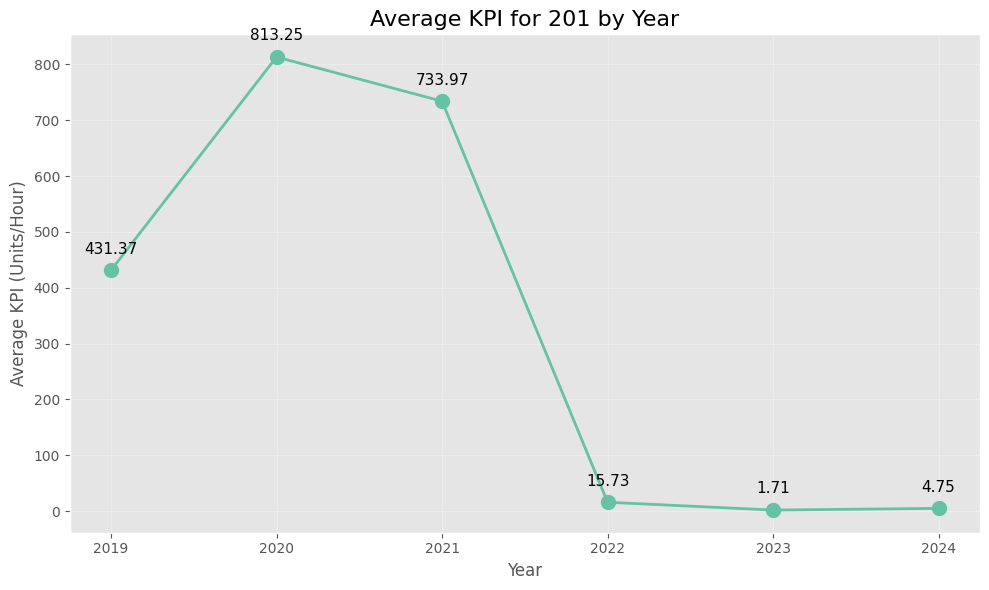

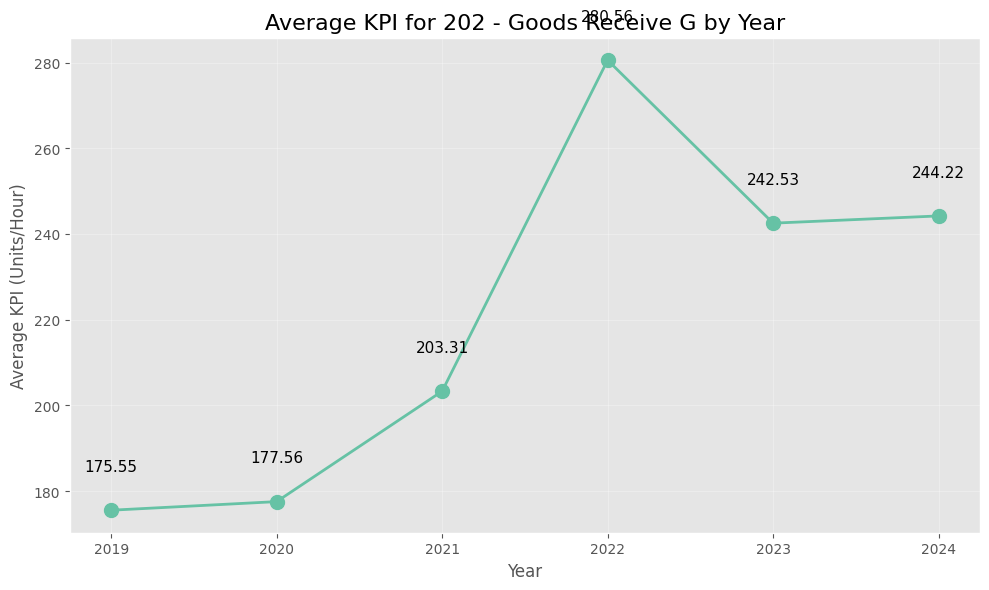

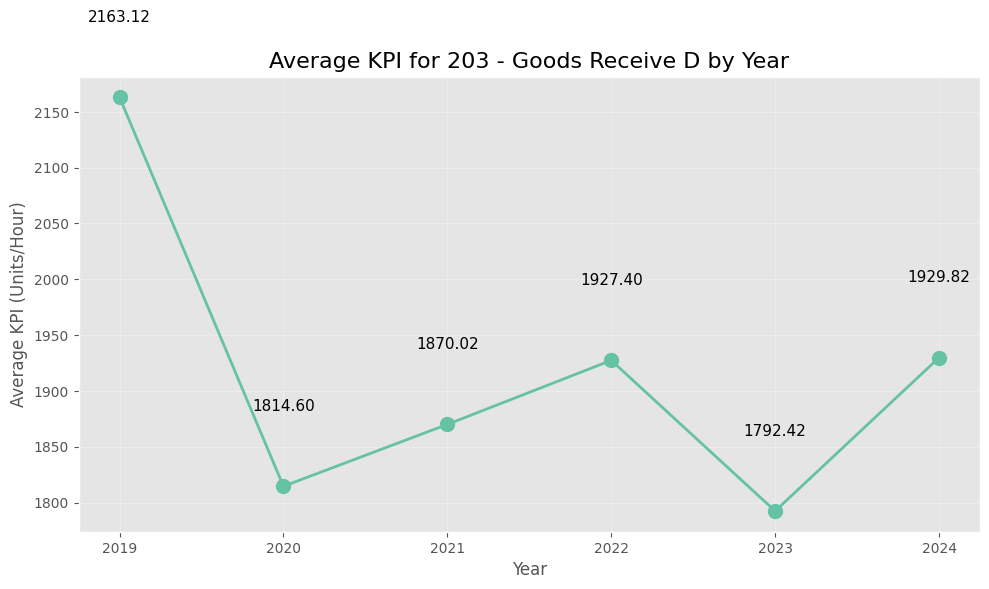

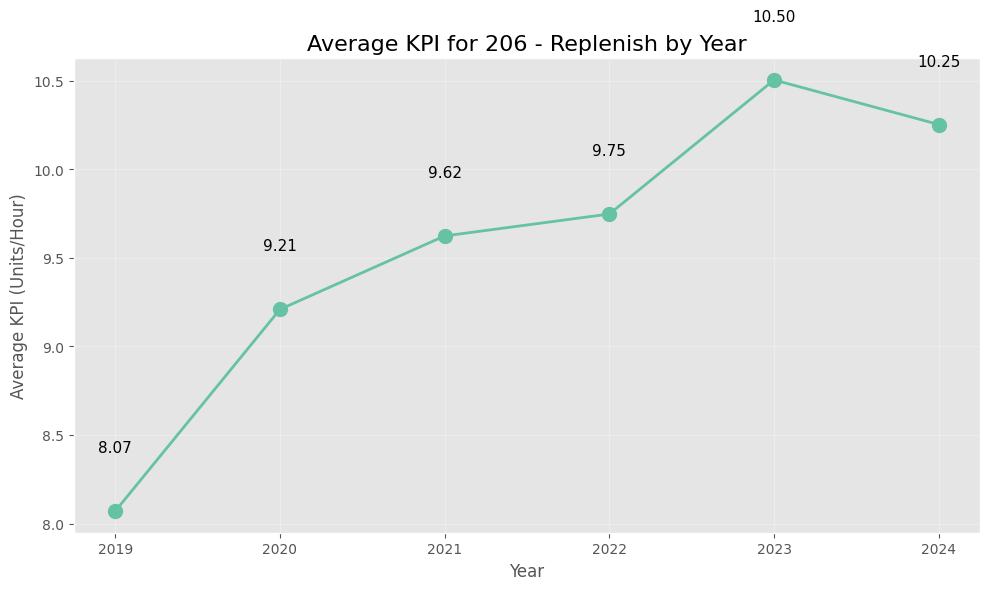

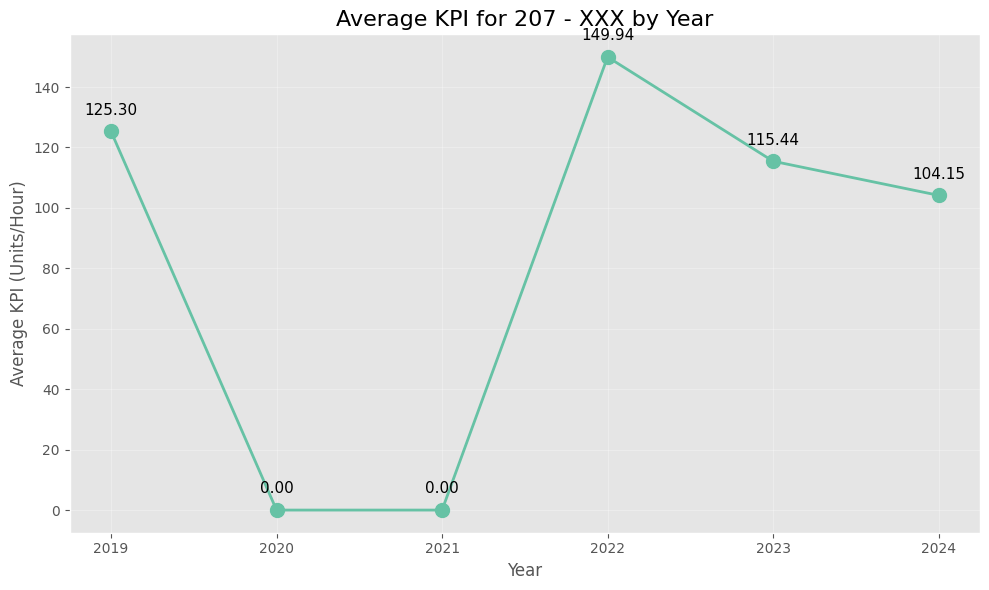

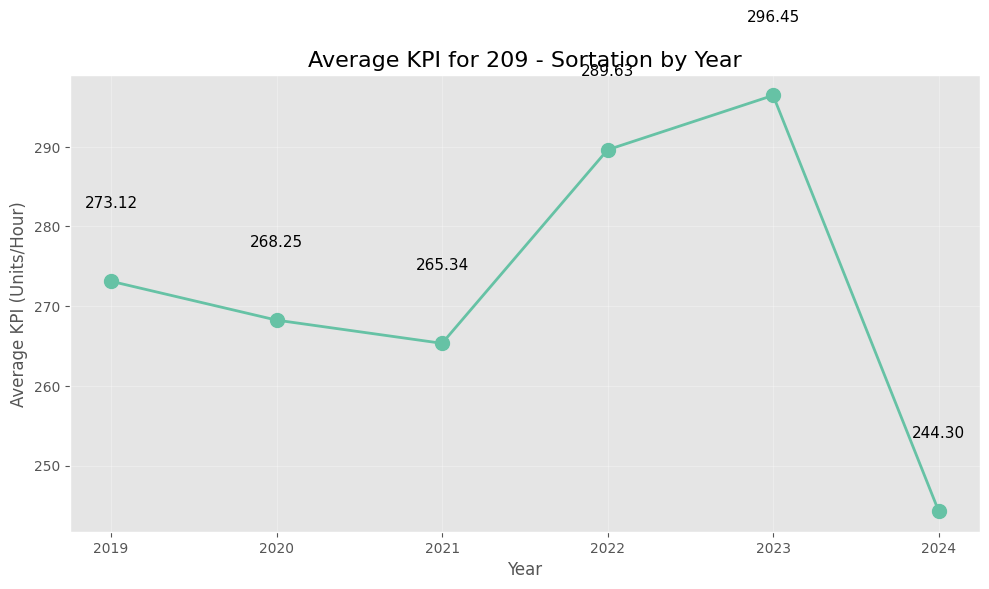

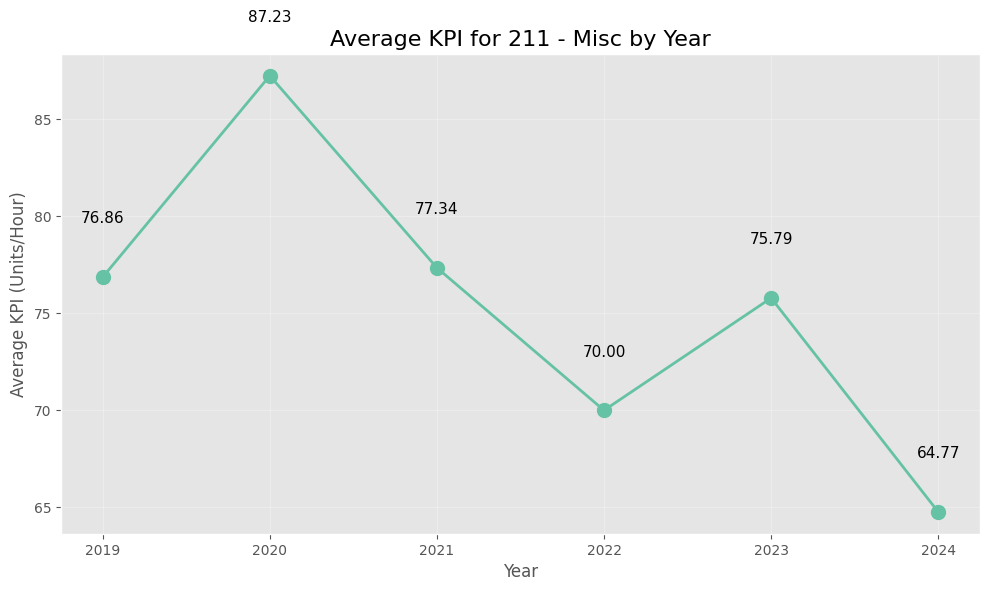

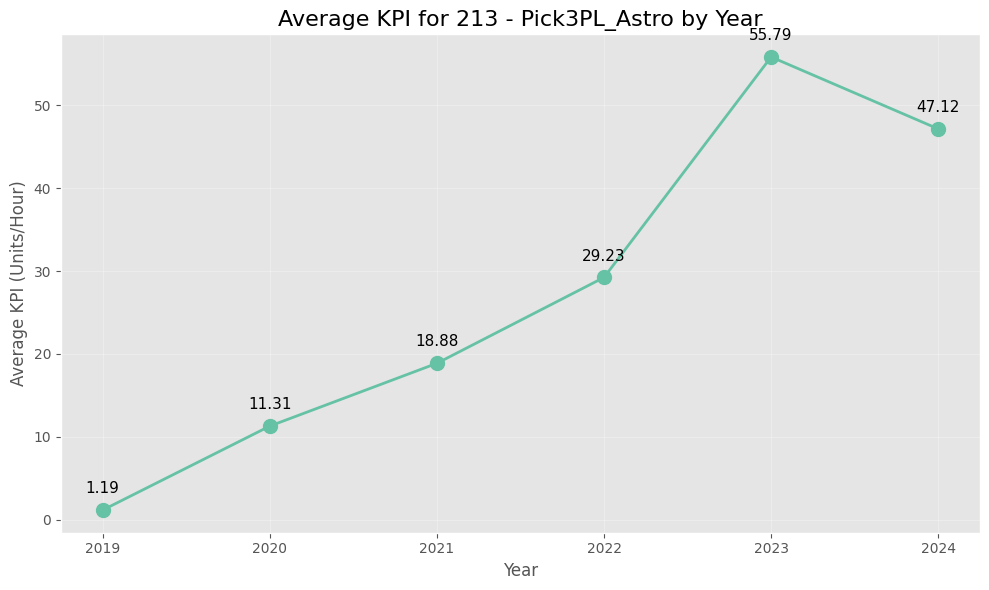

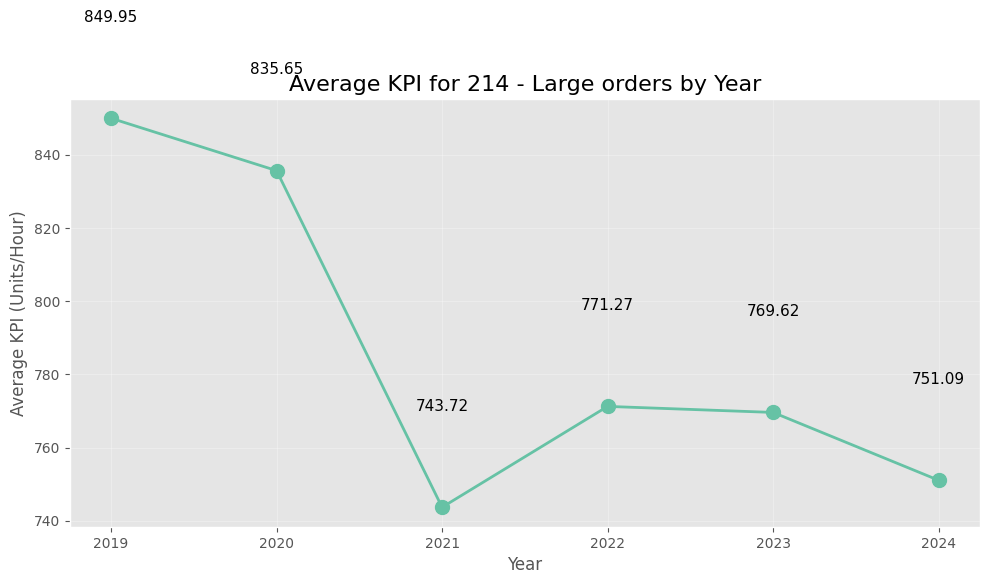

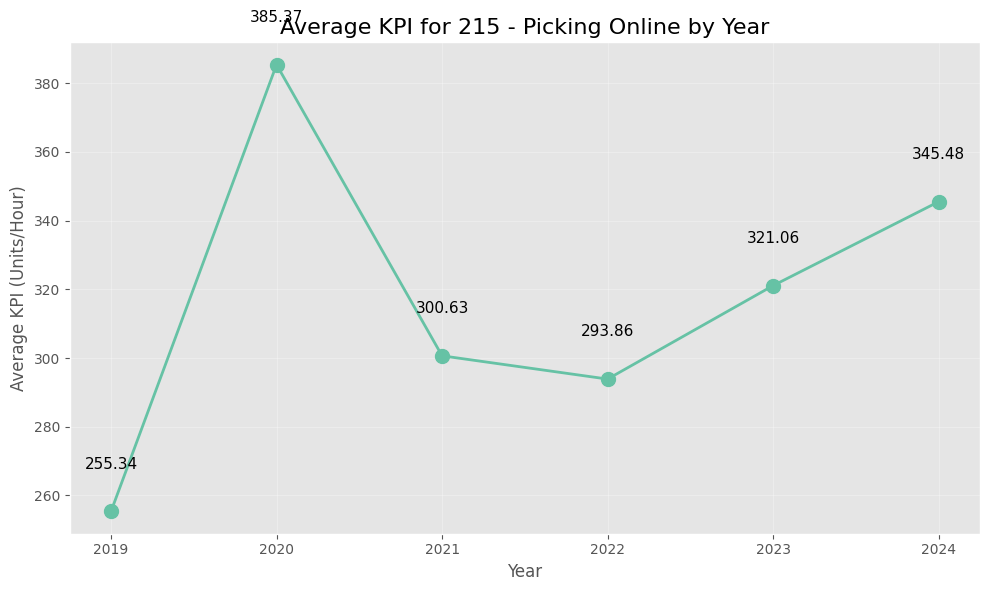

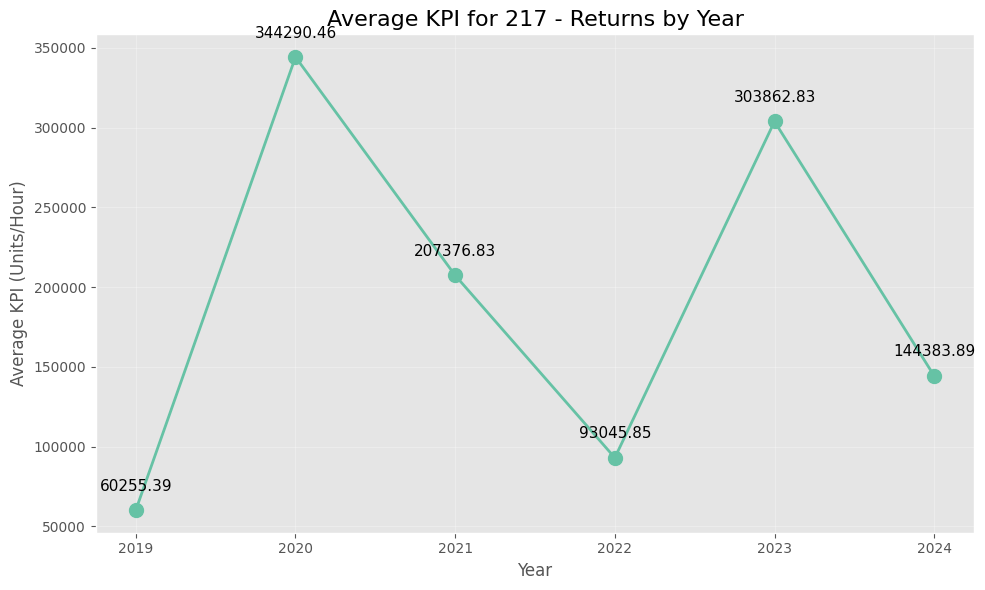

In [49]:
# First, create yearly KPI averages
yearly_kpi = df.groupby(['WorkYear', 'PunchcodeDesc'])['AvgKPI'].mean().reset_index()

# Create a separate plot for each punch code
for punchcode in yearly_kpi['PunchcodeDesc'].unique():
    # Filter data for this punch code
    punchcode_data = yearly_kpi[yearly_kpi['PunchcodeDesc'] == punchcode]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(punchcode_data['WorkYear'], punchcode_data['AvgKPI'], 
             marker='o', linestyle='-', linewidth=2, markersize=10)
    
    plt.title(f'Average KPI for {punchcode} by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average KPI (Units/Hour)', fontsize=12)
    
    # Format x-axis to show only years
    plt.xticks(punchcode_data['WorkYear'], rotation=0)
    
    # Add data labels
    for x, y in zip(punchcode_data['WorkYear'], punchcode_data['AvgKPI']):
        plt.text(x, y + max(punchcode_data['AvgKPI'])*0.03, 
                 f'{y:.2f}', ha='center', va='bottom', fontsize=11)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Optional: Add a pause between plots if viewing in a notebook
    # plt.pause(1)